In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

In [37]:
__file__ = 'C:/Users/antie/Documents/Pole_recherche/Tsunami'

In [2]:
__file__ = 'C:/Users/Gilles/CS/cours/PoleProjet/FormationRecherche/Tsunami/TP/sceance4/Tsunami'

In [3]:
import os

print(os.getcwd())
os.chdir(__file__)
print(os.getcwd())

c:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami\differentiate
C:\Users\Gilles\CS\cours\PoleProjet\FormationRecherche\Tsunami\TP\sceance4\Tsunami


In [21]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

## Create the model

In [37]:
# méthode API Sequential
multilayer_perceptron = keras.models.Sequential([
  keras.layers.Input(shape=(2)),
  #keras.layers.GaussianNoise(stddev=1e-3),
  keras.layers.Dense(20,activation='elu'),
  keras.layers.Dense(20,activation='elu'),
  keras.layers.Dense(20,activation='elu'),
  keras.layers.Dense(1, use_bias=False)
])

In [38]:
multilayer_perceptron.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 20)                60        
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 20)                420       
                                                                 
 dense_25 (Dense)            (None, 1)                 20        
                                                                 
Total params: 920
Trainable params: 920
Non-trainable params: 0
_________________________________________________________________


In [30]:
print(len(multilayer_perceptron.trainable_variables))

8


In [11]:
# Méthode à développer : API Subclassing
# Voir https://www.tensorflow.org/guide/keras/custom_layers_and_models

class PINN (keras.Model): 
    # Physics-informed neural network, très simple pour l'instant

    def __init__(self,units=30,activation='relu',**kwargs):  
        super().__init__(**kwargs) #gère les arguments standard (ex : name)
        self.noise = keras.layers.GaussianNoise(stddev=0) # à modifier pour voir
        self.hidden1 = keras.layers.Dense(units, activation = activation)
        self.hidden2 = keras.layers.Dense(units, activation = activation)
        self.main_output = keras.layers.Dense(1)
    
    def call(self, inputs):
        noise = self.noise(inputs)
        hidden1 = self.hidden1(noise)
        hidden2 = self.hidden2(hidden1)
        main_output = self.main_output(hidden2)
        return main_output

multilayer_perceptron = PINN(units=10,name="model d'API Subclassing pour PINN")

In [32]:
learning_rate = 0.01
training_steps = 1
batch_size = 10
display_step = 1

optimizer = tf.optimizers.Adam(lr=learning_rate)

In [8]:
import Polynomials.polynome4students_v2 as Pstud

frontier_coords = Pstud._set_coords_rectangle(1,1,40)

F_xpy_real = Pstud._set_polynome_xpy_numpy_real(frontier_coords)
F_expxpy_real = Pstud._set_polynome_expxpy_numpy_real(frontier_coords)
F_sinxpy_real = Pstud._set_polynome_sinxpy_numpy_real(frontier_coords)

F_xpy_cmplx = Pstud._set_polynome_xpy_numpy_cmplx(frontier_coords)

In [22]:

# Universal Approximator
def g(x):
  # F_x = Pstud._eval_polynome_numpy(F_xpy_real,x[0,0],x[0,1])
  N_x = multilayer_perceptron(x)
  return N_x

# Given EDO
def f(x):
  return 2*np.pi**2*np.sin(np.pi*x[0,0])*np.sin(np.pi*x[0,1])




def differentiate(model,x):
  with tf.GradientTape(persistent=True) as tape:
    x1, x2 = x[:,0:1], x[:,1:2]
    tape.watch(x1)
    tape.watch(x2)
    u = model(tf.stack([x1[:,0], x2[:,0]], axis=1))
    du_dx = tape.gradient(u,x1)
    du_dy = tape.gradient(u,x2)
  du_dxx = tape.gradient(du_dx,x1) 
  du_dyy = tape.gradient(du_dy,x2)
  return du_dxx,du_dyy




X = np.linspace(0,1,100)
Y = np.linspace(0,1,100)


# Custom loss function to approximate the derivatives
def custom_loss():
  summation = []
  for x in X:  # in mesh
    for y in Y:
      coord = tf.constant([[x,y]],dtype=DTYPE)
      dg_dxx,dg_dyy = differentiate(g,coord)
      summation.append((dg_dxx+dg_dyy + f(coord))**2)
  return tf.sqrt(tf.reduce_mean(summation))

## Train the model

epoch: 0
gradients[-1] : 
 tf.Tensor(
[[ 0.10700806]
 [ 0.01671593]
 [ 0.07321557]
 [-0.09344117]
 [ 0.04326954]
 [-0.01090059]
 [ 0.10631577]
 [-0.11901538]
 [ 0.00210787]
 [ 0.13924003]
 [-0.09625447]
 [-0.05646411]
 [ 0.17283355]
 [ 0.06220049]
 [-0.2519085 ]
 [-0.04159015]
 [-0.09200423]
 [-0.03658623]
 [ 0.0898114 ]
 [ 0.09684898]], shape=(20, 1), dtype=float32) 

gradients[-2] : 
 tf.Tensor(
[-2.2911665e-03  7.2391466e-03 -5.3557628e-03  6.6766641e-03
  1.8294968e-03  0.0000000e+00 -3.8142692e-02  0.0000000e+00
  0.0000000e+00 -1.6940214e-02  0.0000000e+00  0.0000000e+00
 -7.6074041e-02 -1.0408238e-02  3.2845683e-06 -1.3335175e-03
  1.9661358e-04  0.0000000e+00  1.2896430e-06 -2.4620164e-02], shape=(20,), dtype=float32) 

loss: 8.666660 


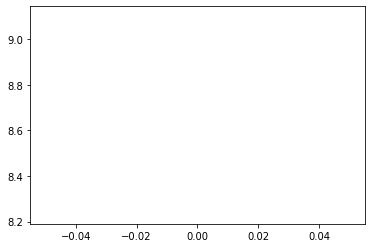

In [39]:
def train_step():
  with tf.GradientTape() as tape:
      loss = custom_loss()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  print("gradients[-1] : \n", gradients[-1],'\n')
  print("gradients[-2] : \n", gradients[-2],'\n')


# Training the Model:

all_losses = []
for i in range(training_steps):
  print ('epoch:',i)
  train_step()
  loss = custom_loss()
  if i % display_step == 0:
    print("loss: %f " % (loss))
  all_losses.append(loss)

plt.plot(np.arange(0,training_steps),all_losses)
plt.show()

## Save the model

In [23]:
multilayer_perceptron.save('my_keras_model_0.h5')

In [ ]:
# API Subclassing
multilayer_perceptron.save_weights('weights_API_Subclassing_model')

## Load the model

In [7]:
multilayer_perceptron = keras.models.load_model('my_keras_model_0.h5')

In [ ]:
# API Subclassing
multilayer_perceptron = PINN()
multilayer_perceptron.load_weights('weights_API_Subclassing_model')

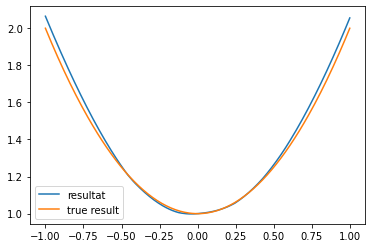

In [12]:
# True Solution (found analitically)
def true_solution(x):
  return x**2 + 1

X = tf.constant(np.linspace(-1, 1, 200),dtype='float32')
result = []
for x in X:
  # print(g(tf.reshape(x,[1])).numpy()[0])
  result.append(g(tf.reshape(x,[1])).numpy()[0])

S = true_solution(X)

plt.plot(X, result, label='resultat')
plt.plot(X, S, label='true result')
plt.legend()
plt.show()

# Questions 

Quelle architecture ? 

Comment éviter l'overfitting ?

Comment exploiter les avantages de l'IA ?

Choix de l'optimizer + regularizer ? + Implémentation ?

Implémentation de système d'EDP à plusieurs inconnues (étant des fonctions bien sûr) ?

Plus rapide ? Comment enlever les boucles `for` ? => batch_gradient_descent ?

Besoin de batch_normalization ? + autres hyperparamètres ?

# Idées

Ajout de bruit en entrée contre l'overfitting 

Une sortie par inconnue